In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
data = pd.concat([pd.read_csv('ElectricityForecaster/Train/Actual_Pre.csv',  parse_dates=True), 
                pd.read_csv('ElectricityForecaster/Train/Actual_Post.csv',  parse_dates=True)], ignore_index=True)

In [4]:
data['time'] = pd.to_datetime(data['time'], dayfirst = True)

1st, 3rd, 26th (+ve)
2nd, 24th (-ve)

seems to have the highest partial_autocorr

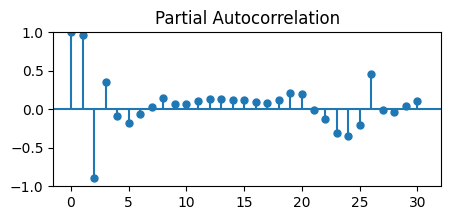

In [39]:
fig, ax = plt.subplots(figsize=(5, 2))
# plot_pacf(data.load_kw, ax=ax, lags=(24,25,26,27,28,29,30))
# plot_pacf(data.load_kw, ax=ax, lags=(0,1,2,3,4,5,6,7,8,9,10))
# plot_pacf(data.load_kw, ax=ax, lags=(15,16,17,18,19,20,21,22,23,24,25))
plot_pacf(data.load_kw, ax=ax, lags=(30))
plt.show()

In [5]:
data.dtypes

Unnamed: 0                 int64
time              datetime64[ns]
load_kw                  float64
pressure_kpa             float64
cloud_cover              float64
humidity                 float64
temperature_c            float64
wind_direction           float64
wind_speed_kmh           float64
date                      object
datetime                  object
month                      int64
hour                       int64
type_of_day                int64
covid                      int64
public_holiday             int64
dtype: object

In [6]:
data.head()

,Unnamed: 0,time,load_kw,pressure_kpa,cloud_cover,humidity,temperature_c,wind_direction,wind_speed_kmh,date,datetime,month,hour,type_of_day,covid,public_holiday
0,0,2017-03-18 00:00:00,1031471.62806,1012.48000,2.12500,79.33333,16.76439,285.25000,6.25375,2017-03-18,00:00:00,3,0,6,0,0
1,1,2017-03-18 01:00:00,1007205.57844,1011.61875,0.00000,82.16667,15.72939,285.00000,9.20500,2017-03-18,01:00:00,3,1,6,0,0
2,2,2017-03-18 02:00:00,986108.40072,1010.72000,2.12500,81.66667,15.81689,316.00000,11.28375,2017-03-18,02:00:00,3,2,6,0,0
3,3,2017-03-18 03:00:00,970760.96692,1011.37625,17.12500,82.25000,15.91939,327.00000,7.16875,2017-03-18,03:00:00,3,3,6,0,0
4,4,2017-03-18 04:00:00,962258.36502,1011.50000,18.62500,82.33333,15.76939,282.25000,0.78000,2017-03-18,04:00:00,3,4,6,0,0


In [5]:
data = data.drop(['Unnamed: 0'], axis=1)

Lagged variables

In [11]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import pacf

In [30]:
def create_lag_features(data):
    y = data['load_L0']
    scaler = StandardScaler()
    features = pd.DataFrame()
    
    partial = pd.Series(data=pacf(y, nlags=168))

    #takes lags with pacf >= 0.2
    lags = list(partial[np.abs(partial) >= 0.2].index)
    
    # df = pd.DataFrame()
    df = data
    
    # avoid to insert the time series itself
    lags.remove(0)
    
    for l in lags:
        df[f"load_L{l}"] = y.shift(l)
    
    # features = pd.DataFrame(scaler.fit_transform(df[df.columns]),
    #                         columns=df.columns)
    # features.index = y.index
    
    return df

In [34]:
final_data = create_lag_features(data)

In [35]:
final_data.columns

Index(['time', 'load_L0', 'pressure_kpa', 'cloud_cover', 'humidity',
       'temperature_c', 'wind_direction', 'wind_speed_kmh', 'date', 'datetime',
       'month', 'hour', 'type_of_day', 'covid', 'public_holiday', 'load_L1',
       'load_L2', 'load_L3', 'load_L24', 'load_L26', 'load_L19', 'load_L23',
       'load_L25', 'load_L50', 'load_L168'],
      dtype='object')

In [6]:
# data = data.rename(columns={'load_kw': 'load'+'_L0'})

In [7]:
# lag_hrs = [1,2,3,24,26]

In [8]:
# for i in range(1,168):
# for i in lag_hrs:
    # data['load' + '_L' + str(i)] = data['load'+'_L0'].shift(i)

In [8]:
final_data = data

In [9]:
final_data = final_data.drop(['date', 'datetime'], axis=1)

In [10]:
final_data.head()

,time,load_kw,pressure_kpa,cloud_cover,humidity,temperature_c,wind_direction,wind_speed_kmh,month,hour,type_of_day,covid,public_holiday
0,2017-03-18 00:00:00,1031471.62806,1012.48000,2.12500,79.33333,16.76439,285.25000,6.25375,3,0,6,0,0
1,2017-03-18 01:00:00,1007205.57844,1011.61875,0.00000,82.16667,15.72939,285.00000,9.20500,3,1,6,0,0
2,2017-03-18 02:00:00,986108.40072,1010.72000,2.12500,81.66667,15.81689,316.00000,11.28375,3,2,6,0,0
3,2017-03-18 03:00:00,970760.96692,1011.37625,17.12500,82.25000,15.91939,327.00000,7.16875,3,3,6,0,0
4,2017-03-18 04:00:00,962258.36502,1011.50000,18.62500,82.33333,15.76939,282.25000,0.78000,3,4,6,0,0


In [39]:
#handling na in the first week (bc no lagged variables)
# final_data=final_data.fillna(0)

In [11]:
final_data.shape

(33600, 13)

In [12]:
filename = r"xgb_data.csv"
final_data.to_csv(filename, index=False, header=True)